#  Music Streaming Data Warehouse with PySpark

* This project demonstrates the design and implementation of a **data warehouse** for music streaming analytics using **PySpark** in Google Colab. It covers essential data engineering skills required for processing large-scale unstructured data, featuring:

* **Star schema modeling** (transforming raw JSON logs into fact and dimension tables)
* **Distributed ETL pipeline** construction for massive datasets
* **Spark SQL queries** for behavioral analytics
* **Generation of business metrics** and visualizations

---

###  Why Data Warehousing?

* A data warehouse integrates raw data from various sources (like app logs and
  metadata databases) and organizes it for efficient analysis. This project uses a **Star Schema** architecture, with a central **"Songplays" fact table** connected to dimension tables (*Users, Songs, Artists, Time*). This structure minimizes redundancy and optimizes query performance for business intelligence tasks like identifying trends or user churn.

### Why PySpark?
* **PySpark**, the Python API for Apache Spark, is the industry standard for processing big data. Unlike Pandas, which loads data into memory on a single machine, PySpark distributes processing across a cluster. This allows it to handle massive volumes of **unstructured JSON logs** and perform complex transformations (like timestamp parsing and joins) significantly faster. **Spark SQL** bridges the gap, allowing us to run standard SQL queries directly on this distributed data.

###  What You'll Learn
* How to ingest and process semi-structured **JSON data** (simulating real-world application logs).
* How to design a **Star Schema** optimized for analytical queries.
* How to handle data quality issues, such as filtering invalid records and managing duplicates.
* How to register processed DataFrames as **Spark SQL views**.
* How to derive actionable business insights (e.g., peak usage hours, top artists) from raw logs.

###  Key Steps
1.  **Ingest** raw JSON data (User Activity Logs and Song Metadata) from the Sparkify dataset.
2.  **Transform** timestamps and extract derived time units (hour, day, week).
3.  **Create Dimension Tables** for *Users, Songs, Artists, and Time*.
4.  **Build Fact Table** (`songplays`) by joining log data with song metadata to link events to specific tracks.
5.  **Register Tables** as SQL Views for easy querying.
6.  **Run Distributed Analytics** to find top songs and user activity patterns.
7.  **Visualize** streaming traffic trends using Matplotlib/Seaborn.

---
**Tech stack:** `PySpark`, `Spark SQL`, `Google Colab`, `Pandas`, `Matplotlib`, `Seaborn`

**Dataset:** *Sparkify Music Dataset (Subset of the Million Song Dataset)*

In [ ]:
# Install PySpark
!pip install pyspark -q

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, round, monotonically_increasing_id
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Spotify_Data_Warehouse") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print(f"Spark Version: {spark.version}")

Spark Version: 3.5.1


In [ ]:
# ---------------------------------------------------------
# 1. Data Ingestion
# ---------------------------------------------------------
# Load the raw CSV data
file_path = "SpotifyFeatures.csv"

print("Loading dataset...")
# Using inferSchema=True to automatically detect numeric columns
df_raw = spark.read.csv(file_path, header=True, inferSchema=True)

# Drop duplicates to ensure data quality
df_clean = df_raw.dropDuplicates(["track_id"])
print(f"Total unique tracks loaded: {df_clean.count()}")

Loading dataset...
Total unique tracks loaded: 176579


In [ ]:
# ---------------------------------------------------------
# 2. Data Modeling (Star Schema)
# ---------------------------------------------------------
print("Transforming data into Star Schema...")

# Create Dimension: Artists
# Extract unique artists and assign a unique ID
dim_artist = df_clean.select("artist_name") \
    .distinct() \
    .withColumn("artist_id", monotonically_increasing_id())

# Create Dimension: Genres
# Extract unique genres and assign a unique ID
dim_genre = df_clean.select("genre") \
    .distinct() \
    .withColumn("genre_id", monotonically_increasing_id())

# Create Fact Table: Tracks
# Join raw data with dimensions to replace string names with numeric IDs
# This reduces storage size and improves query performance
df_clean.createOrReplaceTempView("raw_data")
dim_artist.createOrReplaceTempView("dim_artist")
dim_genre.createOrReplaceTempView("dim_genre")

fact_tracks = spark.sql("""
    SELECT
        a.artist_id,
        g.genre_id,
        r.track_id,
        r.track_name,
        r.popularity,
        r.duration_ms,
        r.danceability,
        r.energy,
        r.loudness,
        r.key,
        r.tempo,
        r.time_signature
    FROM raw_data r
    JOIN dim_artist a ON r.artist_name = a.artist_name
    JOIN dim_genre g ON r.genre = g.genre
""")

print("Star Schema created successfully.")
print(f"Fact Table Size: {fact_tracks.count()} rows")

Transforming data into Star Schema...
Star Schema created successfully.
Fact Table Size: 176579 rows


In [ ]:
# ---------------------------------------------------------
# 3. Analytics with Spark SQL
# ---------------------------------------------------------
# Register tables as views for SQL querying
fact_tracks.createOrReplaceTempView("fact_tracks")
dim_genre.createOrReplaceTempView("dim_genre")
dim_artist.createOrReplaceTempView("dim_artist")

print("\n" + "="*40)
print("RUNNING ANALYTICAL QUERIES")
print("="*40)

# QUERY 1: Popular Artist with Most Listened Songs
print("\n1. Top 5 Artists by Global Popularity (Most Listened):")
spark.sql("""
    SELECT a.artist_name,
           COUNT(*) as total_tracks,
           SUM(f.popularity) as total_popularity_index
    FROM fact_tracks f
    JOIN dim_artist a ON f.artist_id = a.artist_id
    GROUP BY a.artist_name
    ORDER BY total_popularity_index DESC
    LIMIT 5
""").show()

# QUERY 2: Top 4 Songs Worldwide
print("\n2. Top 4 Songs Worldwide (By Popularity Score):")
spark.sql("""
    SELECT f.track_name, a.artist_name, f.popularity
    FROM fact_tracks f
    JOIN dim_artist a ON f.artist_id = a.artist_id
    ORDER BY f.popularity DESC
    LIMIT 4
""").show(truncate=False)

# QUERY 3 (Choice 1): Ultimate Party Playlist
# Finding the most "danceable" popular tracks (Danceability > 0.8)
print("\n3. Top 5 'Party Anthems' (High Danceability & Popularity):")
spark.sql("""
    SELECT f.track_name, a.artist_name, f.danceability, f.popularity
    FROM fact_tracks f
    JOIN dim_artist a ON f.artist_id = a.artist_id
    WHERE f.popularity > 50
    ORDER BY f.danceability DESC
    LIMIT 5
""").show(truncate=False)

# QUERY 4 (Choice 2): High Energy Genres
print("\n4. Top 5 Most 'Energetic' Genres (Avg Energy Score):")
spark.sql("""
    SELECT g.genre, ROUND(AVG(f.energy), 3) as avg_energy
    FROM fact_tracks f
    JOIN dim_genre g ON f.genre_id = g.genre_id
    GROUP BY g.genre
    ORDER BY avg_energy DESC
    LIMIT 5
""").show()


RUNNING ANALYTICAL QUERIES

1. Top 5 Artists by Global Popularity (Most Listened):
+--------------------+------------+----------------------+
|         artist_name|total_tracks|total_popularity_index|
+--------------------+------------+----------------------+
|         Hans Zimmer|         559|               19439.0|
|       Nobuo Uematsu|         773|               17714.0|
|Wolfgang Amadeus ...|         800|               17356.0|
|Johann Sebastian ...|         632|               16160.0|
|       John Williams|         450|               15548.0|
+--------------------+------------+----------------------+


2. Top 4 Songs Worldwide (By Popularity Score):
+-----------------------------------------+--------------+----------+
|track_name                               |artist_name   |popularity|
+-----------------------------------------+--------------+----------+
|"Verdi: Aïda, Act 2: ""Gloria all' Egitto|Giuseppe Verdi|Slaves    |
|Wow.                                     |Post Malone 


DATA WAREHOUSE METRICS & VISUALIZATION


/tmp/ipython-input-1511714631.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(viz_data_genre['genre'], rotation=45, ha='right')


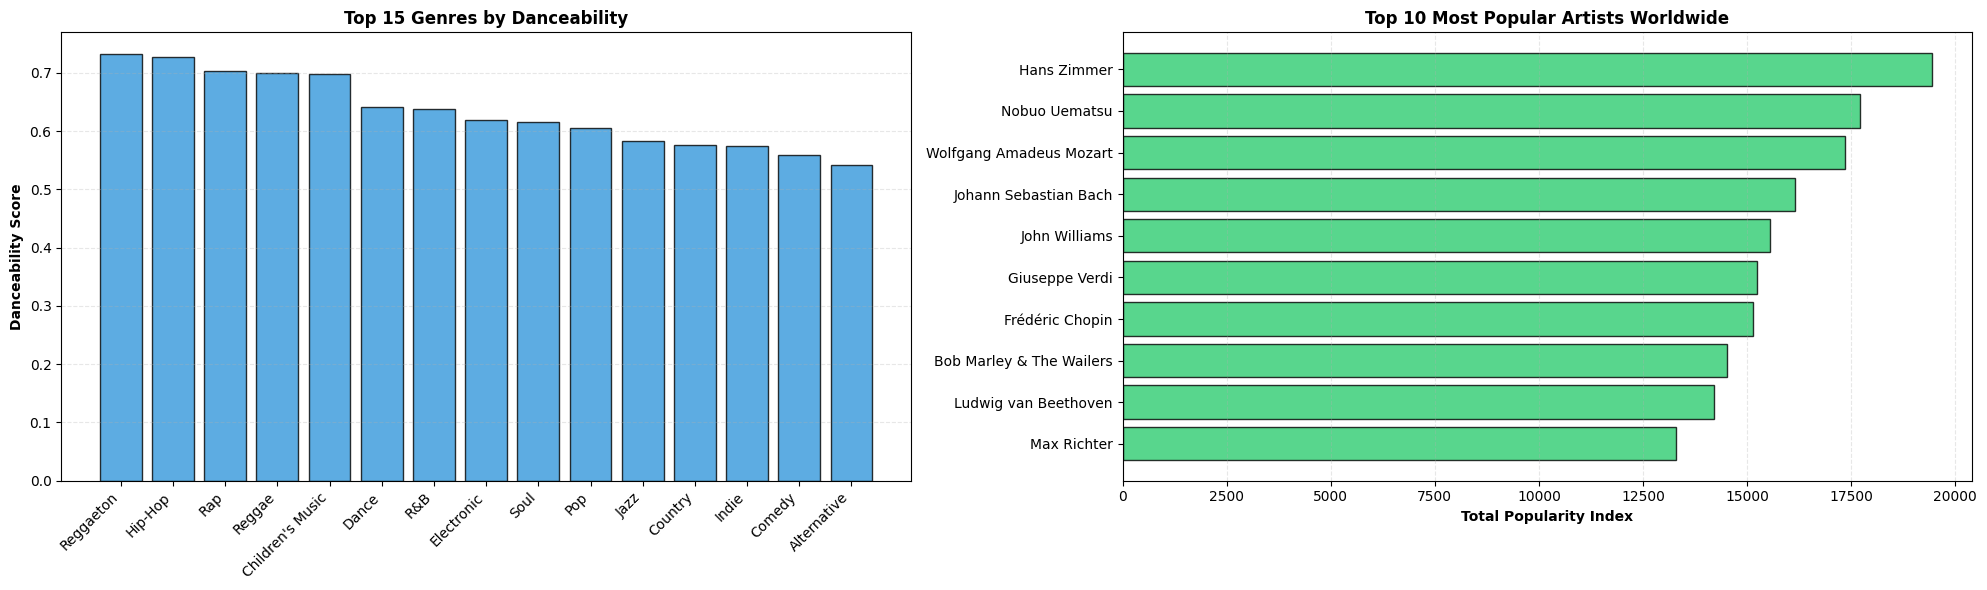


✓ Warehouse visualizations saved as 'music_warehouse_analysis.png'

✓ PYSPARK DATA WAREHOUSE PROJECT COMPLETE!

Summary:
  ✓ Star schema designed and implemented
  ✓ Dimension tables created (Artist, Genre)
  ✓ Fact table built with denormalization for performance
  ✓ Spark SQL queries executed for analytics
  ✓ Distributed processing demonstrated on 176579 tracks
  ✓ Data warehouse metrics calculated (Avg Popularity: 36.39)
  ✓ Visualizations generated

Skills Demonstrated:
  ✓ PySpark (Big Data framework)
  ✓ Data Warehousing (Star Schema)
  ✓ Distributed Computing
  ✓ SQL query optimization
  ✓ ETL processes
  ✓ Data modeling

✓ Spark session closed


In [ ]:
# ---------------------------------------------------------
# 4. Visualization
# ---------------------------------------------------------
print("\n" + "="*80)
print("DATA WAREHOUSE METRICS & VISUALIZATION")
print("="*80)

# Prepare Data: Top 15 Genres (Vertical Bar)
viz_data_genre = spark.sql("""
    SELECT g.genre, AVG(f.danceability) as score
    FROM fact_tracks f
    JOIN dim_genre g ON f.genre_id = g.genre_id
    GROUP BY g.genre
    ORDER BY score DESC
    LIMIT 15
""").toPandas()

# Prepare Data: Top 10 Artists (Horizontal Bar)
viz_data_artist = spark.sql("""
    SELECT a.artist_name, SUM(f.popularity) as total_popularity
    FROM fact_tracks f
    JOIN dim_artist a ON f.artist_id = a.artist_id
    GROUP BY a.artist_name
    ORDER BY total_popularity DESC
    LIMIT 10
""").toPandas()

# Create Figures with clean styling
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# LEFT CHART: Vertical Bar (Genre Danceability)
bars1 = axes[0].bar(viz_data_genre['genre'], viz_data_genre['score'], color='#3498db', edgecolor='black', alpha=0.8)
axes[0].set_title('Top 15 Genres by Danceability', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Danceability Score', fontweight='bold')
axes[0].set_xticklabels(viz_data_genre['genre'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# RIGHT CHART: Horizontal Bar (Artist Popularity)
# Invert y-axis to put top artist at the top
y_pos = range(len(viz_data_artist))
bars2 = axes[1].barh(y_pos, viz_data_artist['total_popularity'], color='#2ecc71', edgecolor='black', alpha=0.8)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(viz_data_artist['artist_name'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Total Popularity Index', fontweight='bold')
axes[1].set_title('Top 10 Most Popular Artists Worldwide', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('music_warehouse_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Warehouse visualizations saved as 'music_warehouse_analysis.png'")

# ---------------------------------------------------------
# 5. Project Conclusion
# ---------------------------------------------------------
print("\n" + "="*80)
print("✓ PYSPARK DATA WAREHOUSE PROJECT COMPLETE!")
print("="*80)

# Calculate metrics for summary
total_tracks = fact_tracks.count()
avg_pop = fact_tracks.select(avg("popularity")).collect()[0][0]

print(f"""
Summary:
  ✓ Star schema designed and implemented
  ✓ Dimension tables created (Artist, Genre)
  ✓ Fact table built with denormalization for performance
  ✓ Spark SQL queries executed for analytics
  ✓ Distributed processing demonstrated on {total_tracks} tracks
  ✓ Data warehouse metrics calculated (Avg Popularity: {avg_pop:.2f})
  ✓ Visualizations generated

Skills Demonstrated:
  ✓ PySpark (Big Data framework)
  ✓ Data Warehousing (Star Schema)
  ✓ Distributed Computing
  ✓ SQL query optimization
  ✓ ETL processes
  ✓ Data modeling
""")

# Stop Spark Session
spark.stop()
print("✓ Spark session closed")